# Project 7: Implémentation d’un modèle de scoring
## Notebook 1 - Prétraitement et modélisation des données 

## Index 
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#load">Importation des packets et données</a></li>
    <li><a href="#EDA">Exploration et prétraitement des données</a>
        <ol>
            <li><a href="#feat_eng">Seléction et création des variables / Feature enginnering</a></li> 
            <li><a href="#analysis">Analyse des variables et traitement d'outliers</a></li>
            <li><a href="#transf">Prétraitement /transformation des variables selon leur type (et reduction dim)</a></li>
        </ol>
    </li>    
    <li><a href="#model">Modélisation</a>
        <ol>
            <li><a href="#reg">Régression linéaire multiple</a></li>
            <li><a href="#rf">Méthodes ensemblistes</a></li>
        </ol>
    </li>    
    <li><a href="#comp">Comparaisons - modèle final</a></li>
</ol>





<a id='intro'></a>
## 1. Introduction 

L'objectif de ce projet est de développer un modèle de scoring selon la probabilité de défaut de paiement d'un client, pour aider une société de crédit de consommation dans leur décision d'octroi de prêts. 

Le modèle sera développé à partir des données variés sur les clients (ex. socio-démographiques, historique de demandes de prêt, etc), disponilbes sur [Kaggle](https://www.kaggle.com/c/home-credit-default-risk/data). Il s'agit d'un problème de classification supervisée binaire, car on dispose des 2 classes annotées comme _target_: 0 (clients sans défaut de paiement) et 1 (clients en défaut). Cependant, on s'interesse à prédire la probabilité (entre 0 et 1) associée à la classification d'un client **comme défaut (1) - prob. de défaut paiement** ou pas défaut (0), et non à la classe en elle-même en sortie. Pour ce faire, on utilise la méthode `predict.proba`, lors de l'application du modèle entraîné pour la prédiction. L'évaluation du modèle sera faite è travers d'une métrique adaptée, comme l'AUC-ROC (exactitude n'est pas adaptée dans ce cas, d'autant moins que le _target_ présente des classes desiquilibrées).

Ce 1er notebook est dedié à l'analyse, prétraitement et modélisation des données. Les 2 autres notebooks contienent le code pour le dashboard (_P7_02_) et pour l'implementation du modèle sous forme d'API (_P7_03_) (deployé sur la platform Heroku).

Le diagramme ci-dessous montre la structure relationnelle des données:
<!-- ![](data/home_credit_data.png) -->
<p align="center">
    <img src="data/home_credit_data.png" width="800">   
</p>

<a id='load'></a>
## 2. Importation des packets et données

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

# featuretools for automated feature engineering (https://featuretools.alteryx.com/en/stable/install.html)
# conda install -c conda-forge featuretools
# !pip install featuretools
# import featuretools as ft

# general pre-processing pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.decomposition import PCA

#Models evaluation 
from sklearn import metrics

# Others
import gc
import time
import warnings
warnings.filterwarnings('ignore')

# specific functions for these project
from P7_functions import *

In [2]:
# List files available
print(os.listdir('data/'))
csv_files=[f for f in os.listdir('data/') if '.csv' in f]

['.gitignore', 'application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'home_credit_data.png', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
csv_files=[f for f in os.listdir('data/') if '.csv' in f]
csv_files.remove('HomeCredit_columns_description.csv')
csv_files.remove('sample_submission.csv')
csv_files

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv']

In [4]:
# read and put all DFs in a dict
key_names = ['test','train','bureau','balance','ccard','install_pay','pos_cash_bal','prev_app']
dict_df = {}
for k, file in zip(key_names, csv_files):
    print(k, file)
    dict_df[k]=pd.read_csv('data/'+ str(file), encoding = 'ISO-8859-1')  #uint-8 error in HomeCredit_columns_description.csv

test application_test.csv
train application_train.csv
bureau bureau.csv
balance bureau_balance.csv
ccard credit_card_balance.csv
install_pay installments_payments.csv
pos_cash_bal POS_CASH_balance.csv
prev_app previous_application.csv


In [5]:
data_desc = pd.read_csv('data/HomeCredit_columns_description.csv', encoding = 'ISO-8859-1')

In [6]:
data_desc.Description.tolist()[:5]

['ID of loan in our sample',
 'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)',
 'Identification if loan is cash or revolving',
 'Gender of the client',
 'Flag if the client owns a car']

In [7]:
# reduce memory usage by using more efficient types for the variables (ex. category is better than object if nb categories ~ nb df rows)
# for k, df in dict_df.items():
#     print(k)
#     dict_df[k] = convert_types(df, print_info=True)

<a id='EDA'></a>
## 3. Exploration et prétraitement 

In [6]:
for k, df in dict_df.items():
    print('{}: {}'.format(k, df.shape))

test: (48744, 121)
train: (307511, 122)
bureau: (1716428, 17)
balance: (27299925, 3)
ccard: (3840312, 23)
install_pay: (13605401, 8)
pos_cash_bal: (10001358, 8)
prev_app: (1670214, 37)


In [10]:
print('Training and testing data shapes: ', dict_df['train'].shape, dict_df['test'].shape)
print('proportion of testing set:', dict_df['test'].shape[0]/(dict_df['test'].shape[0]+dict_df['train'].shape[0]))

Training and testing data shapes:  (307511, 122) (48744, 121)
proportion of testing set: 0.13682334283027606


In [11]:
# Data types etc.
display(dict_df['train'].info())
dict_df['test'].dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

float64    65
int64      40
object     16
dtype: int64

**Valeurs manquantes, doubles et uniques:**

In [5]:
miss_values_percent=[]
cols_with_nan=[]
for k, df in dict_df.items():
    miss_values_percent.append(round(df.isna().sum().sum()/len(df),2))
    miss_by_col = df.isnull().sum()
    cols_with_nan.append(len(miss_by_col.loc[miss_by_col!=0]))
    print('\n{} \n% of total NaN: {:.2f} \nNr of entire double rows: {:}'.format(k,
                                                                               round(df.isna().sum().sum()/len(df),2), 
                                                                               df.duplicated().sum()))
    display(df.describe())


test 
% of total NaN: 28.81 
Nr of entire double rows: 0


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000



train 
% of total NaN: 29.76 
Nr of entire double rows: 0


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000



bureau 
% of total NaN: 2.30 
Nr of entire double rows: 0


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08



balance 
% of total NaN: 0.00 
Nr of entire double rows: 0


,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00



ccard 
% of total NaN: 1.53 
Nr of entire double rows: 0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03



install_pay 
% of total NaN: 0.00 
Nr of entire double rows: 0


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06



pos_cash_bal 
% of total NaN: 0.01 
Nr of entire double rows: 0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03



prev_app 
% of total NaN: 6.65 
Nr of entire double rows: 0


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [14]:
for k, df in dict_df.items():
    # Number of unique classes in each categorical column 
    print('\n',k, '\n',df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))


 test 
 NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

 train 
 NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_M

In [15]:
dict_df['train']['SK_ID_CURR'].is_unique

True

In [16]:
miss_values_percent, cols_with_nan

([28.81, 29.76, 2.3, 0.0, 1.53, 0.0, 0.01, 6.65], [64, 67, 7, 0, 9, 2, 2, 16])

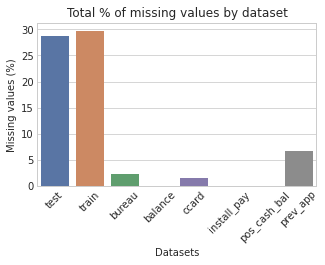

In [17]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5,3))
    sns.barplot(x=list(dict_df.keys()), y=miss_values_percent, palette='deep')
    plt.xticks(rotation=45)
    plt.ylabel('Missing values (%)'), plt.xlabel('Datasets')
    plt.title('Total % of missing values by dataset')

In [18]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    print(len(total.loc[total!=0]), 'columns with missing values out of', data.shape[1])
    
    return pd.concat([total, percent], axis=1, keys=['Total_missing', 'Percentage'])

In [19]:
mis_values = missing_data(dict_df['train'])

67 columns with missing values out of 122


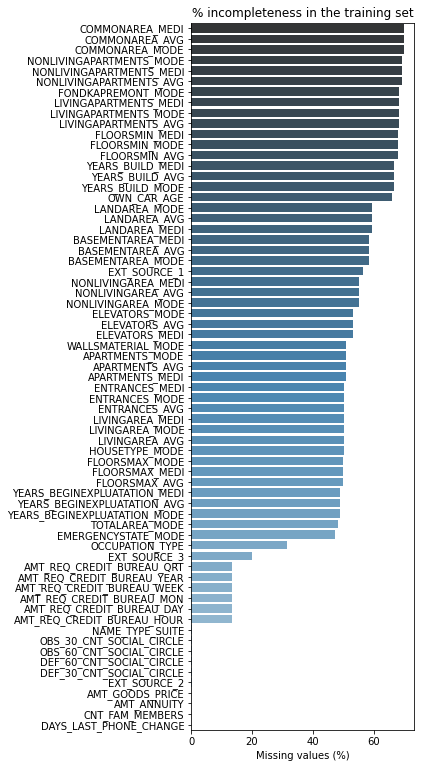

In [20]:
plt.figure(figsize=(4,13))
sns.barplot(y=mis_values.loc[mis_values['Percentage']!=0].index, x=mis_values.loc[mis_values['Total_missing']!=0]['Percentage'].values, palette='Blues_d')
_=plt.xlabel('Missing values (%)'), plt.title('% incompleteness in the training set')

In [21]:
missing_data(dict_df['test'])

64 columns with missing values out of 121


,Total_missing,Percentage
COMMONAREA_MEDI,33495,68.716150
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
...,...,...
REG_CITY_NOT_WORK_CITY,0,0.000000
REG_CITY_NOT_LIVE_CITY,0,0.000000
LIVE_REGION_NOT_WORK_REGION,0,0.000000
REG_REGION_NOT_WORK_REGION,0,0.000000


In [22]:
# missing values by column in each df
df_missing = pd.DataFrame()
for k, df in dict_df.items():
    df_missing = pd.concat([df_missing, missing_data(df)['Percentage'].to_frame(name=k)],axis=1)

64 columns with missing values out of 121
67 columns with missing values out of 122
7 columns with missing values out of 17
0 columns with missing values out of 3
9 columns with missing values out of 23
2 columns with missing values out of 8
2 columns with missing values out of 8
16 columns with missing values out of 37


In [23]:
# rearrange the ratio of missing values in each columns
df_missing = df_missing.T.stack().reset_index()
df_missing.columns = ['df', 'column', 'missing_percent']
df_missing.head(3)

,df,column,missing_percent
0,test,COMMONAREA_MEDI,68.71615
1,test,COMMONAREA_AVG,68.71615
2,test,COMMONAREA_MODE,68.71615


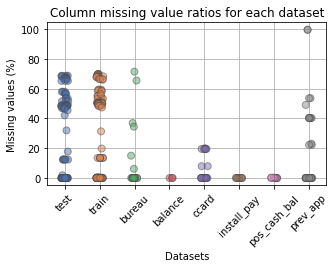

In [24]:
plt.figure(figsize=(5,3))
sns.stripplot(x='df', y='missing_percent', data=df_missing, linewidth=1, alpha = 0.5, size=7, palette='deep')
plt.xticks(rotation=45)
plt.ylabel('Missing values (%)'), plt.xlabel('Datasets')
plt.title('Column missing value ratios for each dataset')
plt.grid()

**Distribution de la variable _target_:**

In [25]:
df_train = dict_df['train']

0    0.92
1    0.08
Name: TARGET, dtype: float64


(<matplotlib.axes._subplots.AxesSubplot at 0x15601b74640>,
 Text(0.5, 1.0, 'Target distribution'),
 Text(0, 0.5, 'Frenquency'))

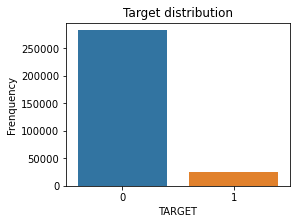

In [26]:
print(df_train.TARGET.value_counts(normalize=True).round(2))
plt.figure(figsize=(4,3))
sns.countplot(df_train.TARGET), plt.title('Target distribution'), plt.ylabel('Frenquency')

**Observations:**
- Train et test sets présentent 30% des valeurs manquantes sur la totalité des valeurs, reparties en plusieurs colonnes (> 50% colonnes présentent des valeurs manquantes dans les 2 jeux des données, dont la plupart plus de 40%).
- Plusieurs variables, comme _DAYS_BIRTH_ (âge du client en jours) et _DAYS_EMPLOYED_ présentent des valuers négatifs, car sont relatives au jour de la demande de prêt, passser à positives. La valeur max de _DAYS_EMPLOYED_ et autres variables _DAYS..._ en `prev_app` est positive et anormalement élevé (~1000 ans) - remplacer par nan.  
- Quelques variables catégorielles n'ont pas le même nb de valeurs (classes) uniques, et doivent être uniformisées (entre train et test sets au moins, voir d'autres stes si utiles). Plusieurs sont binaires (distributions binomiales).
-Les classes de la variable de sortie (TARGET) sont très desiquilibrées. On pourrait utiliser un algorithme pour _oversampling-downsampling_ chaque classe de maniere plus robuste (ex. SOMTE pour creation de nouvelles observations sans répetition, avec neighbors...), car un simple oversampling avec répetition des observations de la classe 1 peut conduire facilement à overfitting. Ou bien utiliser des métriques adaptés au problème pour l'evaluation du modèle.

In [27]:
data_desc.loc[data_desc['Row'].isin(['DAYS_BIRTH','DAYS_EMPLOYED'])]['Description'].tolist()

["Client's age in days at the time of application",
 'How many days before the application the person started current employment']

### Uniformisation et combinaison des dataframes

In [5]:
from contextlib import contextmanager

In [6]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [123]:
# Aggregations in dataframes before merging
def agg_variables(df, df_name, group_var, cat='count'):
    '''Aggregates variables in df along group_var (ID)
    to prepare them before merging'''
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    original_columns = list(df.columns)
    numerical_columns = df.select_dtypes(exclude='object').columns
    categorical_columns = df.select_dtypes('object').columns
    
    # agg dict for categorical features
    if cat=='mode':  
        cat_aggregations = {}
        for col in categorical_columns:
            cat_aggregations[col] = lambda x: x.mode()[0]  #mode of each categotical variable    
    else:      
        # One-hot encoding for categorical columns with get_dummies
        df = pd.get_dummies(df, columns= categorical_columns)
        new_columns = [c for c in df.columns if c not in original_columns]
        cat_aggregations = {}
        for cat in new_columns:
            cat_aggregations[cat] = ['mean']  #relative freq of each class in each categorical var
    
    # agg dict for numeric features
    num_aggregations = {}
    for col in numerical_columns:
        num_aggregations[col] = ['median']
    
    df_agg = df.groupby(group_var).agg({**num_aggregations, **cat_aggregations})
    df_agg.drop(group_var, axis=1, inplace=True)
    df_agg.columns = pd.Index([df_name + '_' + e[0] + '_' + e[1] for e in df_agg.columns.tolist()])
    del df
    gc.collect() #to free memory
    return df_agg

In [125]:
ID_train=dict_df['train'].SK_ID_CURR
ID_test=dict_df['test'].SK_ID_CURR

data = dict_df['train'].append(dict_df['test'])
data.shape

# to get train and test separated back 
# train = data.loc[data['SK_ID_CURR'].isin(ID_train)]
# test = data.loc[data['SK_ID_CURR'].isin(ID_test)].drop('TARGET', axis=1)

(356255, 122)

**Données sur prêts anterieurs dans d'autres institutions**
> Combiner `balance` avec `bureau`.

In [20]:
dict_df['bureau'].columns, dict_df['balance'].columns

(Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
        'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
        'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
        'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
        'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
        'AMT_ANNUITY'],
       dtype='object'),
 Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object'))

In [76]:
# ex of 1 previous loan details
dict_df['balance'].loc[dict_df['balance']['SK_ID_BUREAU']==5715449]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
27,5715449,0,C
28,5715449,-1,C
29,5715449,-2,C
30,5715449,-3,C
31,5715449,-4,C
32,5715449,-5,C
33,5715449,-6,0
34,5715449,-7,0
35,5715449,-8,0
36,5715449,-9,0


In [118]:
df_balance = dict_df['balance'].copy()
df_balance['MONTHS_BALANCE_last'] = df_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].transform('max') #value of last month (max case negative count)
df_balance['MONTHS_BALANCE_count'] = df_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].transform('count') 

# Keep only last month_balance  
# df_balance.drop_duplicates('SK_ID_BUREAU', keep='first', inplace=True) # if they're not ordered better to do as below
index=np.where(df_balance['MONTHS_BALANCE']==df_balance['MONTHS_BALANCE_last'])
df_balance=df_balance.loc[index]

# pass to positive months 
df_balance.drop(['MONTHS_BALANCE'], axis=1, inplace=True)
df_balance['MONTHS_BALANCE_last'] = np.abs(df_balance.MONTHS_BALANCE_last)

In [148]:
df_balance.MONTHS_BALANCE_last.hist()
plt.show()
sns.countplot(df_balance.STATUS), plt.yscale('log')

La plupart des prêts anterieurs sont en état fermé (C) ou inconnu (X) pour le dernier mois (ce mois va répresenter des prêts encore récents), tandis que des valuers du dernier mois de paiement plus elevées representeront des prêts plus anciens.

In [120]:
# merging bureau_balance with bureau
dict_df['bureau'] = dict_df['bureau'].merge(df_balance, how='left', on='SK_ID_BUREAU')
del df_balance
dict_df['bureau'].columns

7406

In [126]:
#Aggregate previous loans data by current loan ID (SK_ID_CURR) - 1 by client 
with timer("Process bureau"):
        bureau_agg = agg_variables(dict_df['bureau'], group_var = 'SK_ID_CURR', df_name = 'bureau')
#         bureau_agg = agg_variables(dict_df['bureau'], group_var = 'SK_ID_CURR', df_name = 'bureau', cat='mode')
        print('bureau_agg df shape:', bureau_agg.shape)
        data =  data.merge(bureau_agg, right_index = True, left_on = 'SK_ID_CURR', how = 'outer') #data.join(bureau_agg, how='left', on='SK_ID_CURR')
        # Add variable nb_previous_loans
        previous_loans_count = dict_df['bureau'].groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'bureau_previous_loans_count'})
        data = data.merge(previous_loans_count, how='left', on='SK_ID_CURR')
        del bureau_agg, previous_loans_count
        gc.collect()

bureau_agg df shape: (305811, 45)
Process bureau - done in 7s


In [139]:
data.shape[1]

168

**Données sur prêts anterieurs chez Home Credit**
> Combiner `pos_cash_bal`, `ccard` et `install_pay` avec `prev_app`.
>- `pos_cash_bal`: on prend les valeurs correspondantes au dernier mois paiement (variable dernier mois peut diferencier entre prêts + et - récents, mais peut-être pas très utile. On creer aussi nb de mois de paiement. SK_DPD (_days past due_) agrégée par mediane des mois.

In [167]:
dict_df['prev_app'].columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [ ]:
# Preprocess previous_applications.csv

# Days 365243 values -> nan
dict_df['prev_app']['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
dict_df['prev_app']['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
dict_df['prev_app']['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
dict_df['prev_app']['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
dict_df['prev_app']['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [197]:
# index rate in common 
print(dict_df['prev_app']['SK_ID_PREV'].isin(dict_df['install_pay']['SK_ID_PREV']).sum()/len(dict_df['prev_app'])) #tous les id existent dans les 2
print(dict_df['prev_app']['SK_ID_PREV'].isin(dict_df['pos_cash_bal']['SK_ID_PREV']).sum()/len(dict_df['prev_app'])) 
print(dict_df['prev_app']['SK_ID_PREV'].isin(dict_df['ccard']['SK_ID_PREV']).sum()/len(dict_df['prev_app']))

0.5741210407768106
0.5381963029887188
0.05564257035326012


In [181]:
data.shape

(356255, 168)

In [166]:
dict_df['install_pay'].columns, dict_df['ccard'].columns, dict_df['pos_cash_bal'].columns

(Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
        'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
        'AMT_INSTALMENT', 'AMT_PAYMENT'],
       dtype='object'),
 Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
        'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
        'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
        'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
        'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
        'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
        'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
        'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
        'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
        'SK_DPD_DEF'],
       dtype='object'),
 Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
        'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
        'SK_DPD_DEF']

In [164]:
# dict_df['ccard'].groupby('SK_ID_CURR').count()['SK_ID_PREV'].sort_values(ascending=False)
# dict_df['install_pay'].groupby('SK_ID_CURR').count()['SK_ID_PREV'].sort_values(ascending=False)

SK_ID_CURR
186401    192
311118    178
120076    140
128827    129
432607    128
         ... 
334453      1
104083      1
277744      1
151215      1
135005      1
Name: SK_ID_PREV, Length: 103558, dtype: int64

In [158]:
dict_df['ccard'].groupby('SK_ID_CURR').count()['SK_ID_PREV']
# df_cash.loc[(df_cash['SK_DPD'] != 0) & (df_cash['SK_ID_PREV']==1624098)]
dict_df['ccard'].loc[dict_df['ccard']['SK_ID_CURR']==100006]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
520387,1489396,100006,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
584804,1489396,100006,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
655566,1489396,100006,-5,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1347528,1489396,100006,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1399895,1489396,100006,-4,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1636141,1489396,100006,-6,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0


In [40]:
df_cash['MONTHS_BALANCE_last'] =df_cash.groupby('SK_ID_PREV')['MONTHS_BALANCE'].transform('max') #value of last month (max case negative count)
df_cash['MONTHS_BALANCE_count'] = df_cash.groupby('SK_ID_PREV')['MONTHS_BALANCE'].transform('count') # nb of months_balance
df_cash['SK_DPD_median'] = df_cash.groupby('SK_ID_PREV')['SK_DPD'].transform('median') #median of delayed days by month
# Keep only last month_balance  
index=np.where(df_cash['MONTHS_BALANCE']==df_cash['MONTHS_BALANCE_last'])
df_cash=df_cash.loc[index]

df_cash['MONTHS_BALANCE_last'] = np.abs(df_cash.MONTHS_BALANCE)
df_cash.drop(['MONTHS_BALANCE','SK_DPD','SK_DPD_DEF'], axis=1, inplace=True)

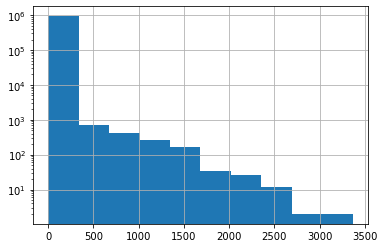

(<matplotlib.axes._subplots.AxesSubplot at 0x1ce9651beb0>,
 None,
 (array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>))

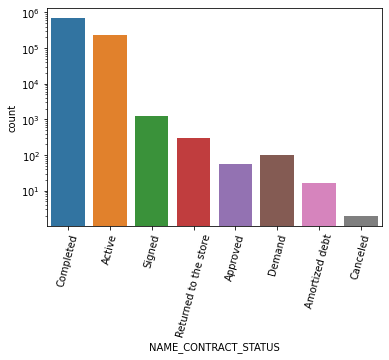

In [63]:
df_cash.SK_DPD_median.hist(log=True)
plt.show()
sns.countplot(df_cash.NAME_CONTRACT_STATUS), plt.yscale('log'), plt.xticks(rotation=75)

In [65]:
# merging pos_cash_balance with previous_application 
df_prev_app = dict_df['prev_app'].copy()
df_prev_app = df_prev_app.merge(df_cash, on='SK_ID_PREV',how='left')

In [75]:
df_ccard = dict_df['ccard'].copy()

In [101]:
# df_ccard.groupby('SK_ID_PREV').count()
df_ccard.loc[df_ccard['SK_ID_PREV']==1000018]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
277653,1000018,394447,-5,40934.070,45000,0.0,2335.500,0.0,2335.500,2250.00,...,40934.070,40934.070,0.0,2,0.0,2.0,1.0,Active,0,0
1375415,1000018,394447,-6,38879.145,45000,13500.0,51042.645,0.0,37542.645,0.00,...,37542.645,37542.645,3.0,15,0.0,12.0,0.0,Active,0,0
2159094,1000018,394447,-2,136695.420,135000,0.0,22827.330,0.0,22827.330,6206.67,...,136024.920,136024.920,0.0,11,0.0,11.0,4.0,Active,0,0
2192275,1000018,394447,-3,113862.285,135000,13500.0,69156.945,0.0,55656.945,2263.77,...,109150.785,109150.785,3.0,14,0.0,11.0,3.0,Active,0,0
2559582,1000018,394447,-4,44360.505,45000,0.0,2032.560,0.0,2032.560,2250.00,...,44360.505,44360.505,0.0,2,0.0,2.0,2.0,Active,0,0


In [103]:
dict_df['ccard'].drop(columns=['AMT_PAYMENT_CURRENT','AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
                               'CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_POS_CURRENT','CNT_DRAWINGS_OTHER_CURRENT',
                               'AMT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT'], 
                      inplace=True)

In [90]:
# ind_last_month = df_ccard.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()

# STATUS for the last month (to merge to the aggregated dataframe later)

# NAME_CONTRACT_STATUS_last = df_ccard.loc[ind, ['SK_ID_PREV','NAME_CONTRACT_STATUS']]
# NAME_CONTRACT_STATUS_last = NAME_CONTRACT_STATUS_last.set_index('SK_ID_PREV')
# NAME_CONTRACT_STATUS.columns = ['NAME_CONTRACT_STATUS_last']

In [124]:
df_cash['NAME_CONTRACT_STATUS'].unique()

array(['Completed', 'Active', 'Signed', 'Returned to the store',
       'Approved', 'Demand', 'Amortized debt', 'Canceled'], dtype=object)

In [ ]:
# NAME_CONTRACT_STATUS
df_cash['NAME_CONTRACT_STATUS'].replace('XNA', np.nan, inplace=True)

In [78]:
df_ccard.loc[ind]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2159094,1000018,394447,-2,136695.420,135000,0.0,22827.33,0.0,22827.33,6206.67,...,136024.920,136024.920,0.0,11,0.0,11.0,4.0,Active,0,0
1150224,1000030,361282,-1,103027.275,112500,0.0,6550.65,0.0,6550.65,5348.52,...,103027.275,103027.275,0.0,3,0.0,3.0,5.0,Active,0,0
2582350,1000031,131335,-1,135786.690,144000,0.0,3325.50,0.0,3325.50,7234.02,...,135786.690,135786.690,0.0,3,0.0,3.0,10.0,Active,0,0
2146369,1000035,436351,-2,0.000,225000,NaN,0.00,NaN,NaN,0.00,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3558682,1000077,181153,-2,0.000,135000,NaN,0.00,NaN,NaN,0.00,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616798,2843476,197090,-2,0.000,45000,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,41.0,Active,0,0
2257668,2843477,168439,-1,0.000,0,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,4.0,Active,0,0
1692332,2843478,424526,-2,0.000,0,0.0,0.00,0.0,0.00,0.00,...,0.000,0.000,0.0,0,0.0,0.0,10.0,Active,0,0
3798957,2843493,337804,-1,70445.790,225000,0.0,0.00,0.0,0.00,3674.79,...,69261.345,69261.345,0.0,0,0.0,0.0,13.0,Active,0,0


In [70]:
ind = dict_df['ccard'].groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()


In [ ]:
# drop redundant columns

dict_df['ccard_bal'] = dict_df['ccard_bal']\
    .drop(columns=['AMT_PAYMENT_CURRENT',
                   'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
                   'CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_POS_CURRENT',
                   'CNT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_ATM_CURRENT',
                   'AMT_DRAWINGS_OTHER

In [40]:
# aggregate along 'SK_ID_PREV'

def abs_min(x): return np.abs(np.min(x))

agg_dict = {'MONTHS_BALANCE': [abs_min], #'count'
            'CNT_INSTALMENT': 'max', # Term of previous credit
            'CNT_INSTALMENT_FUTURE': ['max'], # number of instalments left to pay on the previous credit
            'SK_DPD': ['mean'], # days past due
            'SK_DPD_DEF': ['mean'], # days past due with tolerance
           }

df_cash_grouped = df_cash.groupby('SK_ID_PREV').agg(agg_dict)

In [49]:
df_cash_grouped

,MONTHS_BALANCE__abs_min,CNT_INSTALMENT__max,CNT_INSTALMENT_FUTURE__max,SK_DPD__mean,SK_DPD_DEF__mean
SK_ID_PREV,,,,,
1000001,10,12.0,12.0,0.0,0.0
1000002,54,6.0,4.0,0.0,0.0
1000003,4,12.0,12.0,0.0,0.0
1000004,29,10.0,10.0,0.0,0.0
1000005,56,10.0,10.0,0.0,0.0
...,...,...,...,...,...
2843494,26,48.0,48.0,0.0,0.0
2843495,16,60.0,60.0,0.0,0.0
2843497,21,24.0,24.0,0.0,0.0


#### Uniformisation train et test datasets 
**Variables qualitatives**

In [28]:
df_train = dict_df['train']
df_test = dict_df['test']

In [29]:
print('Columns only in train:\n', df_train.columns.difference(df_test.columns))
print('Columns only in test:\n', df_test.columns.difference(df_train.columns))
# set(df_train.columns) - set(df_test.columns) # or with set to make math operations

Columns only in train:
 Index(['TARGET'], dtype='object')
Columns only in test:
 Index([], dtype='object')


In [30]:
# categorical varibales with different classes between train and test
cols = df_train.select_dtypes('object').nunique()[df_train.select_dtypes('object').nunique() - df_test.select_dtypes('object').nunique() > 0].index
display(df_train.select_dtypes('object').nunique() - df_test.select_dtypes('object').nunique()[df_train.select_dtypes('object').nunique() - df_test.select_dtypes('object').nunique() > 0])
print('')

for c in cols:
    c_train = set(df_train[c].unique())
    c_test = set(df_test[c].unique())
    diff = c_train - c_test
    print(c, diff)

CODE_GENDER                   1.0
EMERGENCYSTATE_MODE           NaN
FLAG_OWN_CAR                  NaN
FLAG_OWN_REALTY               NaN
FONDKAPREMONT_MODE            NaN
HOUSETYPE_MODE                NaN
NAME_CONTRACT_TYPE            NaN
NAME_EDUCATION_TYPE           NaN
NAME_FAMILY_STATUS            1.0
NAME_HOUSING_TYPE             NaN
NAME_INCOME_TYPE              1.0
NAME_TYPE_SUITE               NaN
OCCUPATION_TYPE               NaN
ORGANIZATION_TYPE             NaN
WALLSMATERIAL_MODE            NaN
WEEKDAY_APPR_PROCESS_START    NaN
dtype: float64


CODE_GENDER {'XNA'}
NAME_INCOME_TYPE {'Maternity leave'}
NAME_FAMILY_STATUS {'Unknown'}


In [732]:
# Homogenize these values (replace them in df_train by nan) - to then input or drop 

# df_train['CODE_GENDER'] = df_train['CODE_GENDER'].map(lambda x: x if x != 'XNA' else np.nan)
df_train['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
df_train['NAME_INCOME_TYPE'].replace('Maternity leave', np.nan, inplace=True)
df_train['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)